In [2]:
import importlib
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

def check_and_install(libraries):
    for lib in libraries:
        try:
            importlib.import_module(lib)
            print(f"{lib} is already installed.")
        except ImportError:
            print(f"{lib} is not installed. Installing now...")
            install_package(lib)
            print(f"{lib} has been successfully installed.")

# List of libraries to check and install
libraries_to_check = ['stable_baselines3', 'torch', 'matplotlib', 'gdown', 'gymnasium', 'tqdm','rich']

check_and_install(libraries_to_check)

2024-08-09 04:20:03.511304: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 04:20:03.511448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 04:20:03.602557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 04:20:03.765591: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-08-09 04:20:05.480200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


stable_baselines3 is already installed.
torch is already installed.
matplotlib is already installed.
gdown is already installed.
gymnasium is already installed.
tqdm is already installed.
rich is already installed.


In [8]:
import numpy as np

np.load('g2f.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'g2f.npy'

In [3]:
import requests
import os

# URL of the raw file (note the change from blob to raw)
url = "https://github.com/kora-labs/chromax/raw/master/chromax/sample_data/genome.npy"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Get the filename from the URL
    filename = os.path.basename(url)
    
    # Save the content to a file in the current working directory
    with open(filename, 'wb') as f:
        f.write(response.content)
    
    print(f"File '{filename}' has been downloaded to the current working directory.")
else:
    print("Failed to download the file.")

File 'genome.npy' has been downloaded to the current working directory.


In [ ]:
import numpy as np

genome = np.load('genome.npy', allow_pickle=True)
reshaped_genome = np.transpose(genome, (0, 2, 1)) ; print(reshaped_genome.shape)


(371, 2, 9839)


In [ ]:
import torch
from typing import Optional, Dict
from dataclasses import dataclass
import random
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from IPython.display import clear_output
import matplotlib.colors as mcolors

import gymnasium as gym
import torch
import numpy as np
from collections import defaultdict
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import Figure
tensorboard_log = './ppotb'
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Breeding Simulator

In [6]:
"""

This breeding simulation will simulate a single additive trait.

1) we will init a randomized population of size (config.starting_parents, 2, config.n_markers) with 0/1 tensor
2) we will use this starting population to sample the marker effects for our additive trait, which is scaled to be 0/1 mean/var for the population
3) we will store the founder_pop and their founder_phentypes

"""



## BREEDING SIMULATOR
    
class Genome:
    def __init__(self, n_markers: int):
        self.ploidy: int = 2
        self.n_markers: int = n_markers

    def __repr__(self) -> str:
        return f"Genome(ploidy={self.ploidy}, n_markers={self.n_markers})"

class Population:
    def __init__(self, pop_size: int, haplotypes:torch.tensor, genome: Genome, device: torch.device):
        self.pop_size: int = pop_size
        self.genome: Genome = genome
        self.haplotypes: torch.Tensor = haplotypes
        self.device: torch.device = device
        
    def to(self, device: torch.device) -> 'Population':
        self.device = device
        self.haplotypes = self.haplotypes.to(device)
        return self

    def __repr__(self) -> str:
        return f"Population(pop_size={self.pop_size}, genome={self.genome}, device={self.device})"

class Trait:
    def __init__(self, genome: Genome, population: Population, target_mean: float = 0.0, target_variance: float = 1):
        self.genome: Genome = genome
        self.device: torch.device = population.device
        self.target_mean: float = target_mean
        self.target_variance: float = target_variance

        # Use torch.randn with a generator for reproducibility
        generator = torch.Generator(device=self.device)
        generator.manual_seed(torch.initial_seed())  # Use the seed set by torch.manual_seed()
        raw_effects = torch.randn(genome.n_markers, device=self.device, generator=generator)

        centered_effects = raw_effects - raw_effects.mean()
        dosages = population.haplotypes.sum(dim=1)
        founder_values = torch.einsum('ij,j->i', dosages, centered_effects)
        founder_mean = founder_values.mean()
        founder_var = founder_values.var()

        scaling_factor = torch.sqrt(self.target_variance / founder_var)
        self.effects: torch.Tensor = centered_effects * scaling_factor
        self.intercept: torch.Tensor = (torch.tensor(self.target_mean, device=self.device) - founder_mean).detach()

    def to(self, device: torch.device) -> 'Trait':
        self.device = device
        self.effects = self.effects.to(device)
        self.intercept = self.intercept.to(device)
        return self

    def __repr__(self) -> str:
        return f"Trait(target_mean={self.target_mean}, target_variance={self.target_variance}, device={self.device})"


"""
The logic of the breeding simulation. Meiosis(Recombination) + Crossing

All operate on tensors
"""
@staticmethod
def meiosis(selected_haplotypes: torch.Tensor, num_crossovers: int = 1, num_gametes_per_parent: int = 1) -> torch.Tensor:
    """ takes a tensor of parent genomes, (selected_haplotypes) and generates gametes for each parent"""
    num_parents, ploidy, num_markers = selected_haplotypes.shape

    # Repeat each parent's haplotypes num_gametes_per_parent times
    expanded_haplotypes = selected_haplotypes.repeat_interleave(num_gametes_per_parent, dim=0)

    # The rest of the function remains largely the same, but operates on the expanded haplotypes
    total_gametes = num_parents * num_gametes_per_parent

    crossover_points = torch.randint(1, num_markers, (total_gametes, num_crossovers), device=selected_haplotypes.device, generator=torch.Generator(device=selected_haplotypes.device).manual_seed(torch.initial_seed()))
    crossover_points, _ = torch.sort(crossover_points, dim=1)

    crossover_mask = torch.zeros((total_gametes, num_markers), dtype=torch.bool, device=selected_haplotypes.device)
    crossover_mask.scatter_(1, crossover_points, 1)
    crossover_mask = torch.cumsum(crossover_mask, dim=1) % 2 == 1

    crossover_mask = crossover_mask.unsqueeze(1).expand(-1, ploidy, -1)

    start_chromosome = torch.randint(0, ploidy, (total_gametes, 1), device=selected_haplotypes.device)
    start_mask = start_chromosome.unsqueeze(-1).expand(-1, -1, num_markers)

    final_mask = crossover_mask ^ start_mask.bool()

    offspring_haplotypes = torch.where(final_mask, expanded_haplotypes, expanded_haplotypes.roll(shifts=1, dims=1))

    # Return only the first haplotype for each meiosis event
    return offspring_haplotypes[:, 0, :]

@staticmethod
def random_cross(gamete_tensor: torch.Tensor, total_crosses: int) -> torch.Tensor:
    """ takes output from meiosis (gamete tensor) and outputs offspring """
    num_gametes, n_markers = gamete_tensor.shape

    # Double the gamete tensor until we have enough for the total crosses
    while num_gametes < 2 * total_crosses:
        gamete_tensor = torch.cat([gamete_tensor, gamete_tensor], dim=0)
        num_gametes *= 2

    # Randomly select gametes for crossing
    gamete_indices = torch.randperm(num_gametes, device=gamete_tensor.device)
    parent1_indices = gamete_indices[:total_crosses]
    parent2_indices = gamete_indices[total_crosses:2*total_crosses]

    # Create the new population haplotype tensor
    new_population = torch.stack([
        gamete_tensor[parent1_indices],
        gamete_tensor[parent2_indices]
    ], dim=1)

    return new_population
    

@staticmethod
def score_population(haplotypes: torch.Tensor, trait: Trait, h2: float = 1.0, founder_mean: float = 0, founder_std: float = 1):
    dosages = haplotypes.sum(dim=1)
    breeding_values = torch.einsum('ij,j->i', dosages, trait.effects)
    bv_var = breeding_values.var()

    if bv_var == 0 or h2 >= 1:
        phenotypes = breeding_values
    else:
        env_variance = (1 - h2) / (h2 * bv_var.item()+.001)
        env_std = torch.sqrt(torch.tensor(env_variance, device=trait.device))
        env_effects = torch.randn_like(breeding_values) * env_std
        phenotypes = breeding_values + env_effects + trait.intercept

    # Normalize phenotypes
    normalized_phenotypes = (phenotypes - founder_mean) / (founder_std + 1e-6)
    return breeding_values, normalized_phenotypes


@staticmethod
def score_population(haplotypes: torch.Tensor, trait: Trait, h2: float = 1.0, norm_mean: float = 0, norm_std: float = 1):
    dosages = haplotypes.sum(dim=1)
    breeding_values = torch.einsum('ij,j->i', dosages, trait.effects)
    bv_var = breeding_values.var()

    if bv_var == 0 or h2 >= 1:
        phenotypes = breeding_values
    else:
        env_variance = (1 - h2) / h2 * bv_var.item()
        env_std = torch.sqrt(torch.tensor(env_variance, device=trait.device))
        env_effects = torch.randn_like(breeding_values) * env_std
        phenotypes = breeding_values + env_effects + trait.intercept

    # Normalize phenotypes
    normalized_phenotypes = (phenotypes - norm_mean) / norm_std

    return breeding_values, normalized_phenotypes




In [7]:
class SimParams:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.genome = Genome(config.n_markers)

        # Load and prepare genome
        genome = np.load('genome.npy')
        reshaped_genome = np.transpose(genome, (0, 2, 1))
        reshaped_genome = torch.tensor(reshaped_genome, device=self.device).float()
        
        # Sample parents
        random_indices = torch.randperm(reshaped_genome.shape[0])[:config.starting_parents]
        parents = reshaped_genome[random_indices]
        
        # Sample markers
        random_indices = torch.randperm(parents.shape[2])[:config.n_markers]
        parents = parents[:,:,random_indices]

        f1_gametes = meiosis(parents, num_crossovers=config.num_crossovers, num_gametes_per_parent=config.pop_size)
        f1 = random_cross(gamete_tensor=f1_gametes, total_crosses=config.pop_size)

        self.founder_pop = Population(config.pop_size, f1, self.genome, self.device)
        self.trait = Trait(self.genome, self.founder_pop)
        # Calculate founder population statistics
        founder_bv, founder_phenotypes = score_population(self.founder_pop.haplotypes, self.trait, h2=self.config.h2)
        self.founder_mean = founder_phenotypes.mean().item()
        self.founder_std = founder_phenotypes.std().item()

        # Perform burn-in
        new_pop, new_mean = self.burn_in(num_generations=config.burnin_years, genetic_variance_threshold=config.burnin_gvt)
        
        # Update founder population
        self.founder_pop.haplotypes = new_pop
        
        # Calculate normalization parameters based on burn-in population
        _, burn_in_phenotypes = score_population(new_pop, self.trait, h2=self.config.h2)
        self.normalization_mean = burn_in_phenotypes.mean().item()
        self.normalization_std = burn_in_phenotypes.std().item()
        
        mean_start_pop = (score_population(new_pop, self.trait, h2 = self.config.h2)[0].mean())
        # Update trait intercept
        self.trait.intercept = torch.tensor(mean_start_pop, device=self.trait.device)

        
    def burn_in(self, num_generations=50, h2=0.1, selection_intensity=0.9, mutation_rate=0.001, genetic_variance_threshold=.4):
        current_pop = self.founder_pop.haplotypes
        current_size = self.config.pop_size

        for generation in range(num_generations):
            # Score the current population
            breeding_values, phenotypes = score_population(current_pop, self.trait)

            # Calculate genetic variance
            genetic_variance = breeding_values.var().item()

            # Introduce mutations if genetic variance is below the threshold
            if genetic_variance < genetic_variance_threshold:
                mutation_mask = torch.rand_like(current_pop) < mutation_rate
                current_pop = torch.where(mutation_mask, 1 - current_pop, current_pop)
            else:
                # Select top individuals
                num_selected = max(int(current_size * selection_intensity), 2)  # Ensure at least 2 parents
                selection = torch.topk(phenotypes, num_selected).indices
                selected_parents = current_pop[selection]

                # Create next generation
                gametes = meiosis(selected_parents, num_gametes_per_parent=self.config.pop_size // num_selected + 1)
                current_pop = random_cross(gametes, total_crosses=self.config.pop_size)

            if generation % 10 == 0 or generation == num_generations - 1:
                print(f"Generation {generation + 1}: "
                    f"Max phenotype = {phenotypes.max().item():.4f}, "
                    f"Max breeding value = {breeding_values.max().item():.4f}, "
                    f"Genetic variance = {genetic_variance:.4f}")

        # Calculate new mean
        final_breeding_values, _ = score_population(current_pop, self.trait, h2=1.0)
        new_mean = final_breeding_values.mean().item()

        return current_pop, new_mean


In [8]:


import numpy as np

from gymnasium import spaces
import numpy as np


import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from collections import defaultdict
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

class GeneralizedVisualizationCallback(BaseCallback):
    def __init__(self, verbose=0, log_freq=2000, window_size=50, target_phenotype=None, best_action_pair=None):
        super().__init__(verbose)
        self.data = defaultdict(lambda: defaultdict(list))
        self.log_freq = log_freq
        self.excluded_metrics = ['TimeLimit.truncated', 'current_generation']
        self.target_phenotype = target_phenotype
        self.best_action_pair = best_action_pair  # Updated to store action pair
        self.window_size = window_size

    def _on_step(self) -> bool:
        info = self.locals['infos'][0]
        obs = self.locals['new_obs']
        
        current_generation = info['current_generation']
        
        # Track all scalar values from the observation space
        for key, value in obs.items():
            if np.isscalar(value) and key not in self.excluded_metrics:
                self.data[key][current_generation].append(value)
        
        # Also track any scalar values from the info dict
        for key, value in info.items():
            if np.isscalar(value) and key not in self.excluded_metrics:
                self.data[key][current_generation].append(value)

        if self.num_timesteps % self.log_freq == 0:
            self.visualize()

        return True

    def visualize(self):
        num_metrics = len(self.data)
        fig, axes = plt.subplots(num_metrics, 1, figsize=(16, 6*num_metrics), sharex=True)
        if num_metrics == 1:
            axes = [axes]

        for idx, (metric, generations) in enumerate(self.data.items()):
            ax = axes[idx]
            num_generations = len(generations)
            colors = plt.cm.viridis(np.linspace(0, 1, num_generations))

            for i, (generation, values) in enumerate(generations.items()):
                if len(values) == 0:
                    continue  # Skip empty data

                steps = np.arange(len(values))

                # Dynamically adjust window size
                effective_window = min(self.window_size, len(values))
                if effective_window < 2:
                    effective_window = 2  # Minimum window size

                # Calculate rolling moving average with adjusted window size
                rolling_avg = np.convolve(values, np.ones(effective_window), 'valid') / effective_window
                rolling_steps = steps[effective_window-1:]

                ax.plot(rolling_steps, rolling_avg, label=f'Generation {generation}', color=colors[i])
                ax.set_title(f'{metric.capitalize()} per Generation')
                ax.set_ylabel(f'Rolling Avg {metric.capitalize()}')
                ax.grid(True)

            # Add target_phenotype line for max_phenotype chart
            if metric == 'max_phenotype' and self.target_phenotype is not None:
                ax.axhline(y=self.target_phenotype, color='r', linestyle='--', label='Target Phenotype')

            # Add best_action lines for selection_intensity and budget_spent charts
            if self.best_action_pair is not None:
                if metric == 'selection_intensity':
                    best_selection_intensity = (self.best_action_pair[0] + 1) / 2 * 0.98 + 0.01
                    ax.axhline(y=best_selection_intensity, color='g', linestyle='--', label='Best Selection Intensity')
                if metric == 'budget_spent':
                    best_budget_allocation = (self.best_action_pair[1] + 1) / 2
                    # ax.axhline(y=best_budget_allocation, color='r', linestyle='--', label='Best Budget Allocation')

        axes[-1].set_xlabel('Steps within Generation')
        plt.tight_layout()
        clear_output(wait=True)
        plt.show()


@dataclass
class SimulationConfig:
    #training
    total_timesteps: int = 2000
    seed: int = 100
    max_generations: int= 50
    #breeding sim parameters
    n_markers: int = 500
    starting_parents: int = 200
    pop_size: int = 500
    h2: float = 0.5
    num_crossovers: int=3
    sparse_reward: bool=False
    #burnin
    burnin_years : int =  20
    burnin_gvt : float = .4



# Environment

## budget

In [9]:

class BudgetEnv(gym.Env):
    def __init__(self, sim_params: SimParams, starting_budget=1000):
        super(BudgetEnv, self).__init__()
        
        self.SP = sim_params
        self.max_generations = sim_params.config.max_generations
        self.current_generation = 0
        self.current_pop = sim_params.founder_pop.haplotypes
        self.selection_intensities = []
        self.founder_mean = sim_params.founder_mean
        self.founder_std = sim_params.founder_std
        self.action_sum = 0.0
        self.starting_budget = starting_budget
        self.remaining_budget = starting_budget
        self.budget_history = []

        # Define action and observation spaces
        # Action space includes selection intensity [0] and budget allocation [1]
        self.action_space = spaces.Box(low=np.array([-1, -1]), high=np.array([1, 1]), shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Dict({
            'genetic_variance': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'remaining_cycles': spaces.Box(low=0, high=self.max_generations, shape=(1,), dtype=np.float32),
            'remaining_budget': spaces.Box(low=0, high=self.starting_budget, shape=(1,), dtype=np.float32),
        })

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_generation = 0
        self.current_pop = self.SP.founder_pop.haplotypes
        self.selection_intensities = []
        self.action_sum = 0.0
        self.remaining_budget = self.starting_budget
        self.budget_history = []
        return self._get_obs(), {}

    def step(self, action):
        # Extract selection intensity and budget allocation from action
        selection_intensity = (action[0] + 1) / 2 * 0.98 + 0.01 # to [0.01,0.99]
        budget_allocation = (action[1] + 1) / 2  # Normalized to [0, 1]

        # Calculate budget to spend
        budget_to_spend = self.remaining_budget * budget_allocation

        # Update remaining budget
        self.remaining_budget -= budget_to_spend
        self.budget_history.append(budget_to_spend)

        self.selection_intensities.append(selection_intensity)
        self.action_sum += selection_intensity
        
        breeding_values, phenotypes = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        
        # Increase offspring based on budget spent (you'll need to define a function for this)
        num_offspring = self._calculate_offspring(self.SP.config.pop_size, budget_to_spend)
        num_selected = max(int(self.current_pop.shape[0] * selection_intensity), 2)
        
        selection = torch.topk(phenotypes, num_selected).indices
        selected_parents = self.current_pop[selection]
        
        gametes = meiosis(selected_parents, num_gametes_per_parent=num_offspring // num_selected + 1)
        self.current_pop = random_cross(gametes, total_crosses=num_offspring)
        
        self.current_generation += 1
        
        new_breeding_values, new_phenotypes = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        done = self.current_generation >= self.max_generations

        # Reward function (you might need to adjust this based on your goals)
        if self.SP.config.sparse_reward:
            reward = new_breeding_values.max().item() - self.founder_mean if done else 0
        else:
            reward = new_breeding_values.max().item() - breeding_values.max().item()

        observation = self._get_obs()
        info = {
            'max_phenotype': new_phenotypes.max().item(),
            'current_generation': self.current_generation,
            'genetic_variance': new_breeding_values.var().item(),
            'selection_intensity': selection_intensity,
            'budget_action': budget_allocation,
            'budget_spent': budget_to_spend
        }

        return observation, reward, done, False, info

    def _get_obs(self):
        breeding_values, _ = score_population(self.current_pop, self.SP.trait, h2=self.SP.config.h2)
        genetic_variance = breeding_values.var().item()
        remaining_cycles = self.max_generations - self.current_generation
        
        return {
            'genetic_variance': np.array([genetic_variance], dtype=np.float32),
            'remaining_cycles': np.array([remaining_cycles], dtype=np.float32),
            'remaining_budget': np.array([self.remaining_budget], dtype=np.float32),
        }

    def _calculate_offspring(self, base_offspring, budget_spent):
        # Define a function to calculate offspring based on budget spent
        # This is a placeholder, you'll need to implement a suitable logic here
        # For example, you could use a linear or exponential relationship
        return int(base_offspring + budget_spent * 1)  # Example: 10 offspring per budget unit




@dataclass
class SimulationConfig:
    #training
    total_timesteps: int = 2000
    seed: int = 100
    max_generations: int= 50
    #breeding sim parameters
    n_markers: int = 500
    starting_parents: int = 200
    pop_size: int = 10
    h2: float = 0.5
    num_crossovers: int=3
    sparse_reward: bool=True
    #burnin
    burnin_years : int =  10
    burnin_gvt : float = .5
    init_pop_size: int = 100



In [10]:


config = SimulationConfig()
config.max_generations = 10
config.sparse_reward = True
SP = SimParams(config)
breeder_env = BudgetEnv(SP, starting_budget=5000)

Generation 1: Max phenotype = 0.6943, Max breeding value = 0.6943, Genetic variance = 1.0000
Generation 10: Max phenotype = 0.0147, Max breeding value = 0.0147, Genetic variance = 0.1399


/tmp/ipykernel_209/2009651635.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.trait.intercept = torch.tensor(mean_start_pop, device=self.trait.device)


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def run_constant_action_pair_baseline_analysis(env, num_episodes=10, num_selection_intensity_actions=20, num_budget_allocation_actions=10):
    def run_constant_action_pair_baseline(env, action_pair, num_episodes):
        results = []
        for _ in range(num_episodes):
            obs, _ = env.reset()
            done = False
            episode_reward = 0
            max_phenotypes = []
            genetic_variances = []

            while not done:
                obs, reward, done, _, info = env.step(np.array(action_pair))
                episode_reward += reward
                max_phenotypes.append(info['max_phenotype'])
                genetic_variances.append(info['genetic_variance'])

            results.append({
                'total_reward': episode_reward,
                'max_phenotypes': max_phenotypes,
                'genetic_variances': genetic_variances
            })

        return results

    # Define ranges of constant actions to test
    selection_intensity_actions = np.linspace(-1, 1, num_selection_intensity_actions)
    budget_allocation_actions = np.linspace(-1, 1, num_budget_allocation_actions)

    # Collect baseline results
    baseline_results = {}
    best_action_pair = None
    best_max_phenotype = float('-inf')
    best_avg_reward = float('-inf')

    for selection_intensity_action in selection_intensity_actions:
        for budget_allocation_action in budget_allocation_actions:
            action_pair = [selection_intensity_action, budget_allocation_action]
            baseline_results[tuple(action_pair)] = run_constant_action_pair_baseline(env, action_pair, num_episodes)

            # Calculate average max phenotype and average total reward for this action pair
            avg_max_phenotype = np.mean([max(r['max_phenotypes']) for r in baseline_results[tuple(action_pair)]])
            avg_total_reward = np.mean([r['total_reward'] for r in baseline_results[tuple(action_pair)]])

            # Update best action pair if this pair performs better
            if avg_max_phenotype > best_max_phenotype:
                best_action_pair = action_pair
                best_max_phenotype = avg_max_phenotype
                best_avg_reward = avg_total_reward

    # Create heatmap data
    heatmap_data = np.zeros((num_budget_allocation_actions, num_selection_intensity_actions))
    for i, selection_intensity_action in enumerate(selection_intensity_actions):
        for j, budget_allocation_action in enumerate(budget_allocation_actions):
            action_pair = (selection_intensity_action, budget_allocation_action)
            if action_pair in baseline_results:
                avg_total_reward = np.mean([r['total_reward'] for r in baseline_results[action_pair]])
                heatmap_data[j, i] = avg_total_reward

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(heatmap_data, cmap='viridis', origin='lower', aspect='auto')

    # Set tick labels
    ax.set_xticks(np.arange(num_selection_intensity_actions))
    ax.set_yticks(np.arange(num_budget_allocation_actions))
    ax.set_xticklabels([f'{val:.2f}' for val in selection_intensity_actions], rotation=45, ha='right')
    ax.set_yticklabels([f'{val:.2f}' for val in budget_allocation_actions])

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Average Total Reward', rotation=-90, va="bottom")

    # Set labels
    ax.set_xlabel('Selection Intensity Action')
    ax.set_ylabel('Budget Allocation Action')
    ax.set_title('Heatmap of Average Total Reward for Action Pairs')

    plt.tight_layout()
    plt.show()

    # Print best action pair information
    best_selection_intensity = (best_action_pair[0] + 1) / 2 * 0.98 + 0.01
    best_budget_allocation = (best_action_pair[1] + 1) / 2

    print("\nBest Action Pair Information:")
    print(f"Best Selection Intensity Action: {best_action_pair[0]:.2f} (SI: {best_selection_intensity:.2f})")
    print(f"Best Budget Allocation Action: {best_action_pair[1]:.2f} (Allocation: {best_budget_allocation:.2f})")
    print(f"Best Max Phenotype: {best_max_phenotype:.2f}")
    print(f"Best Average Reward: {best_avg_reward:.2f}")

    return best_action_pair, best_selection_intensity, best_budget_allocation, best_max_phenotype, best_avg_reward

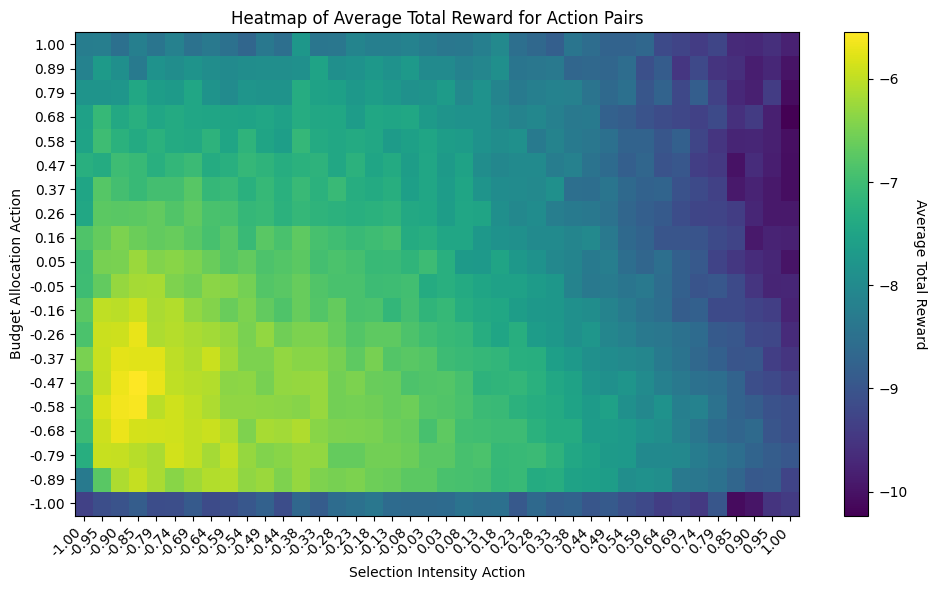


Best Action Pair Information:
Best Selection Intensity Action: -0.85 (SI: 0.09)
Best Budget Allocation Action: -0.47 (Allocation: 0.26)
Best Max Phenotype: 4.71
Best Average Reward: -5.55


In [12]:
import numpy as np
import matplotlib.pyplot as plt


best_action_pair, best_si, best_budget_allocation, best_phenotype, best_reward = run_constant_action_pair_baseline_analysis(breeder_env, num_episodes=20, num_selection_intensity_actions=40, num_budget_allocation_actions=20)

In [13]:
best_action_pair, best_si, best_budget_allocation, best_phenotype, best_reward

([-0.8461538461538461, -0.4736842105263158],
 0.08538461538461538,
 0.2631578947368421,
 4.714528667926788,
 -5.549300742149353)

In [14]:
best_action_pair = (best_si,best_budget_allocation)

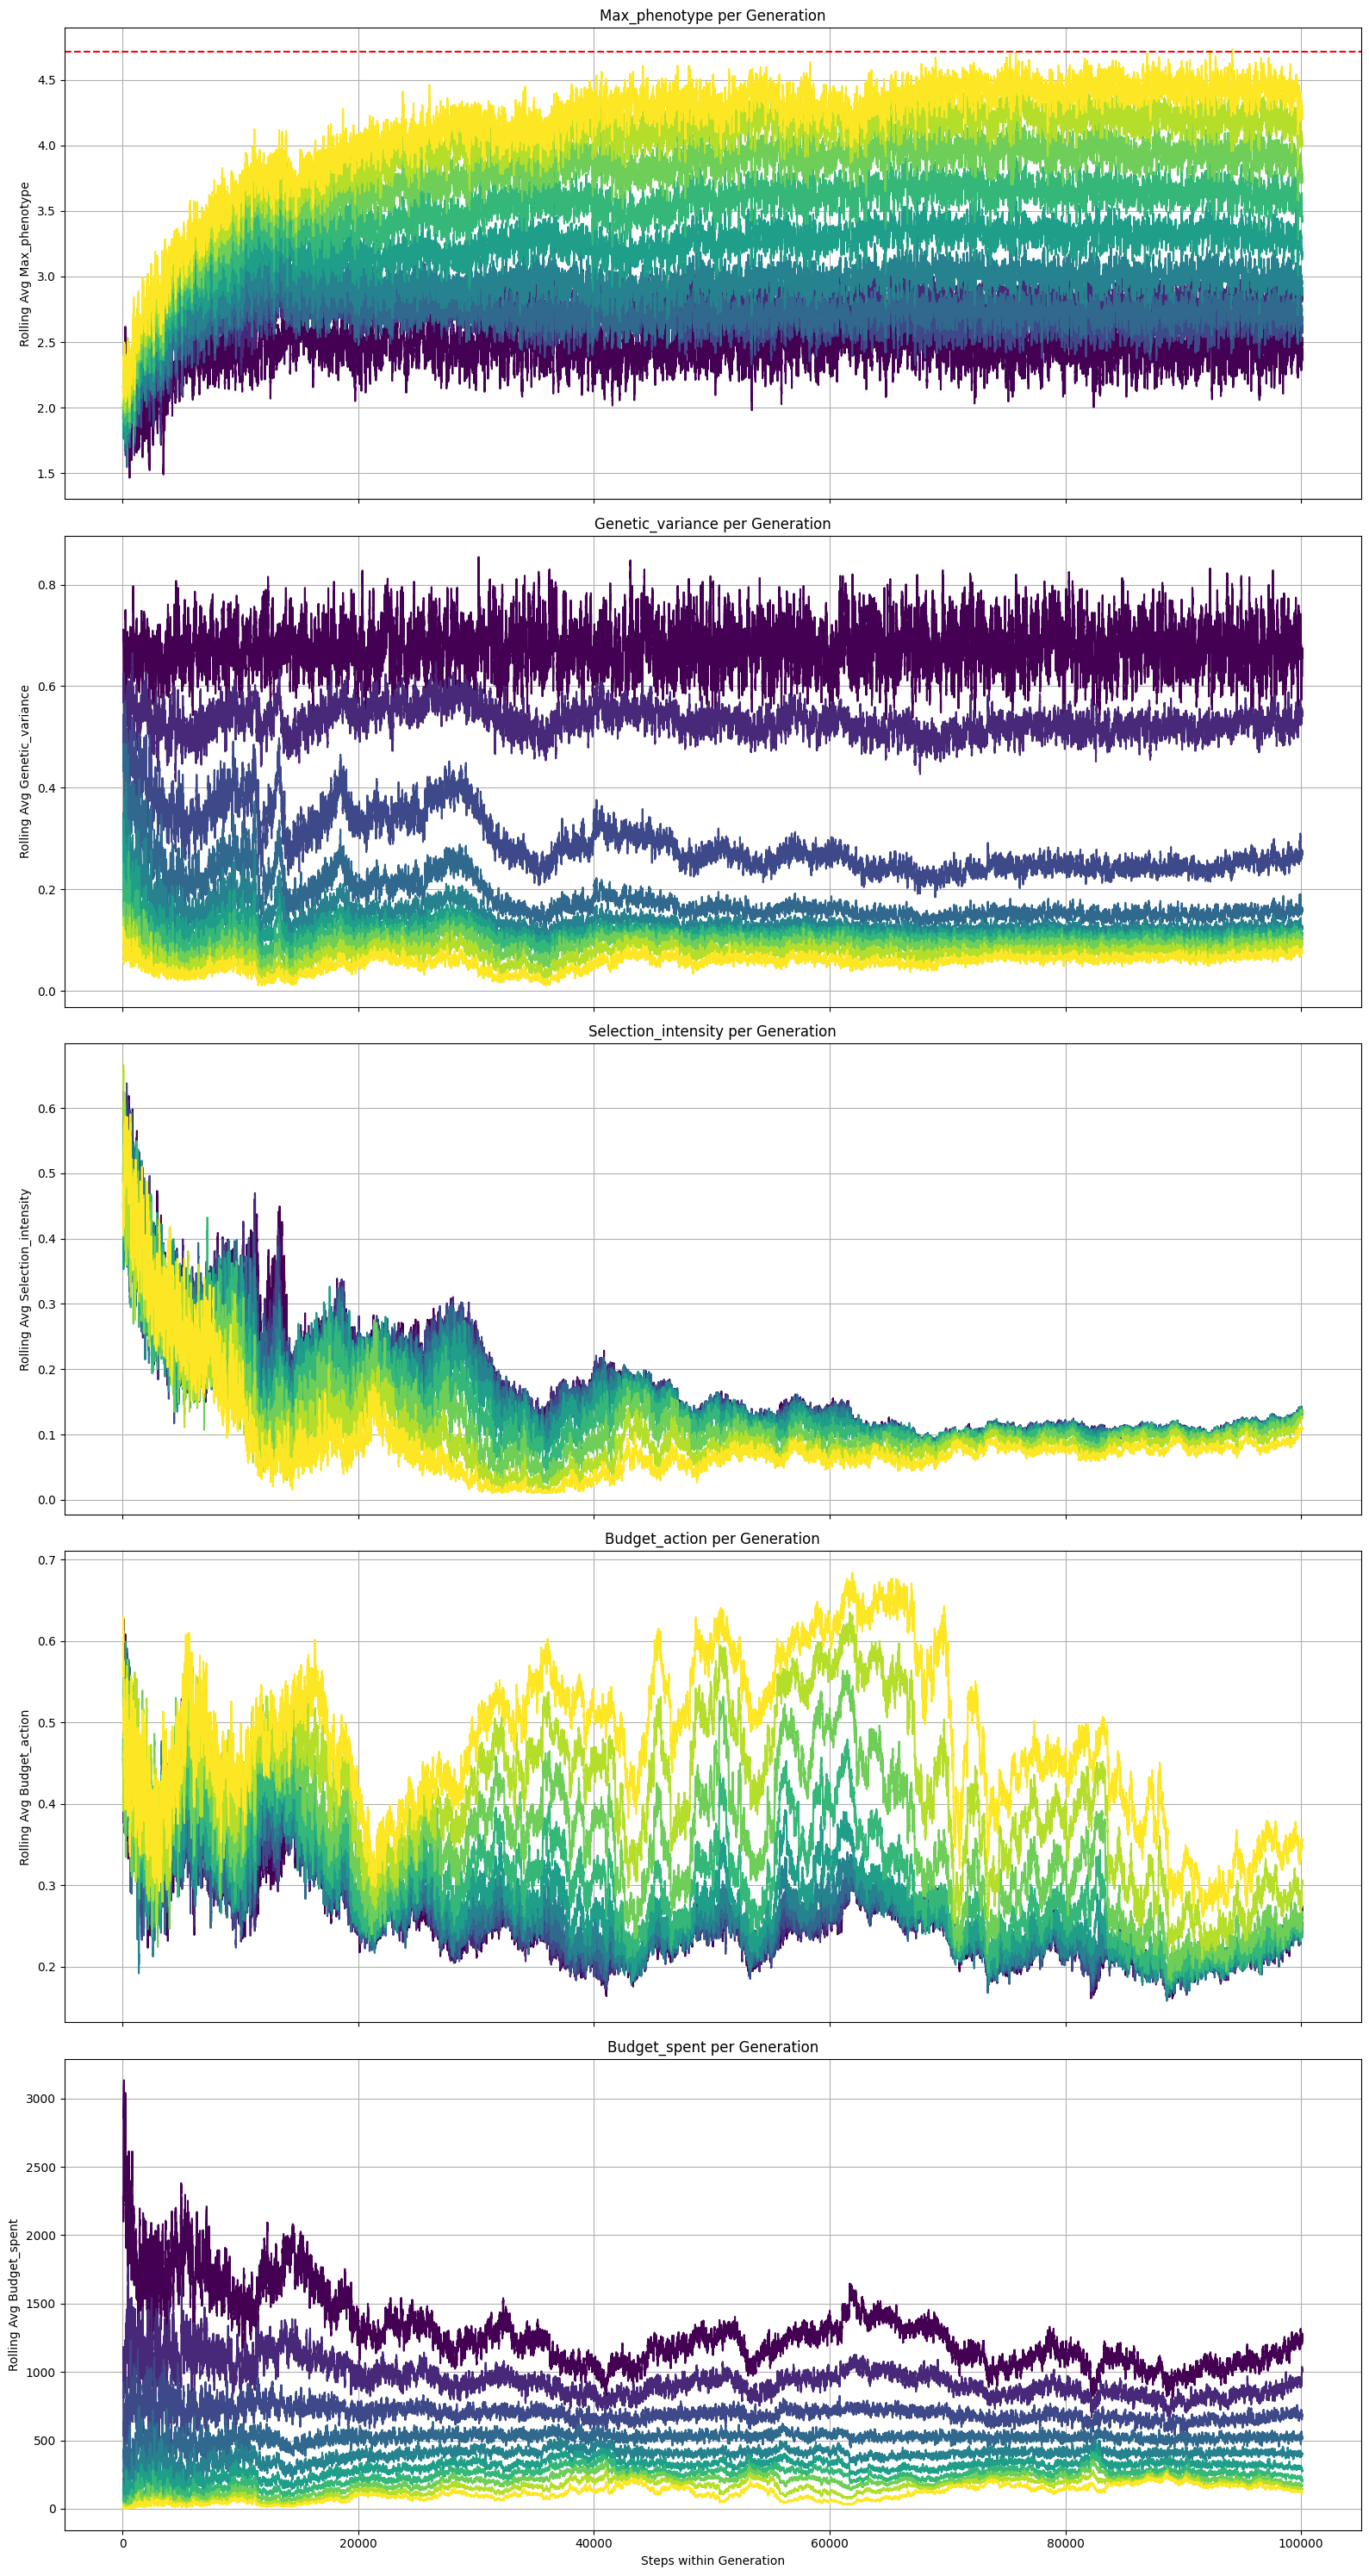

In [15]:

agent = PPO("MultiInputPolicy", breeder_env)
callback = GeneralizedVisualizationCallback(log_freq=1000,
#  best_action_pair=best_action_pair,
  target_phenotype=best_phenotype,
  )

agent.learn(total_timesteps=1000000 ,callback = callback)

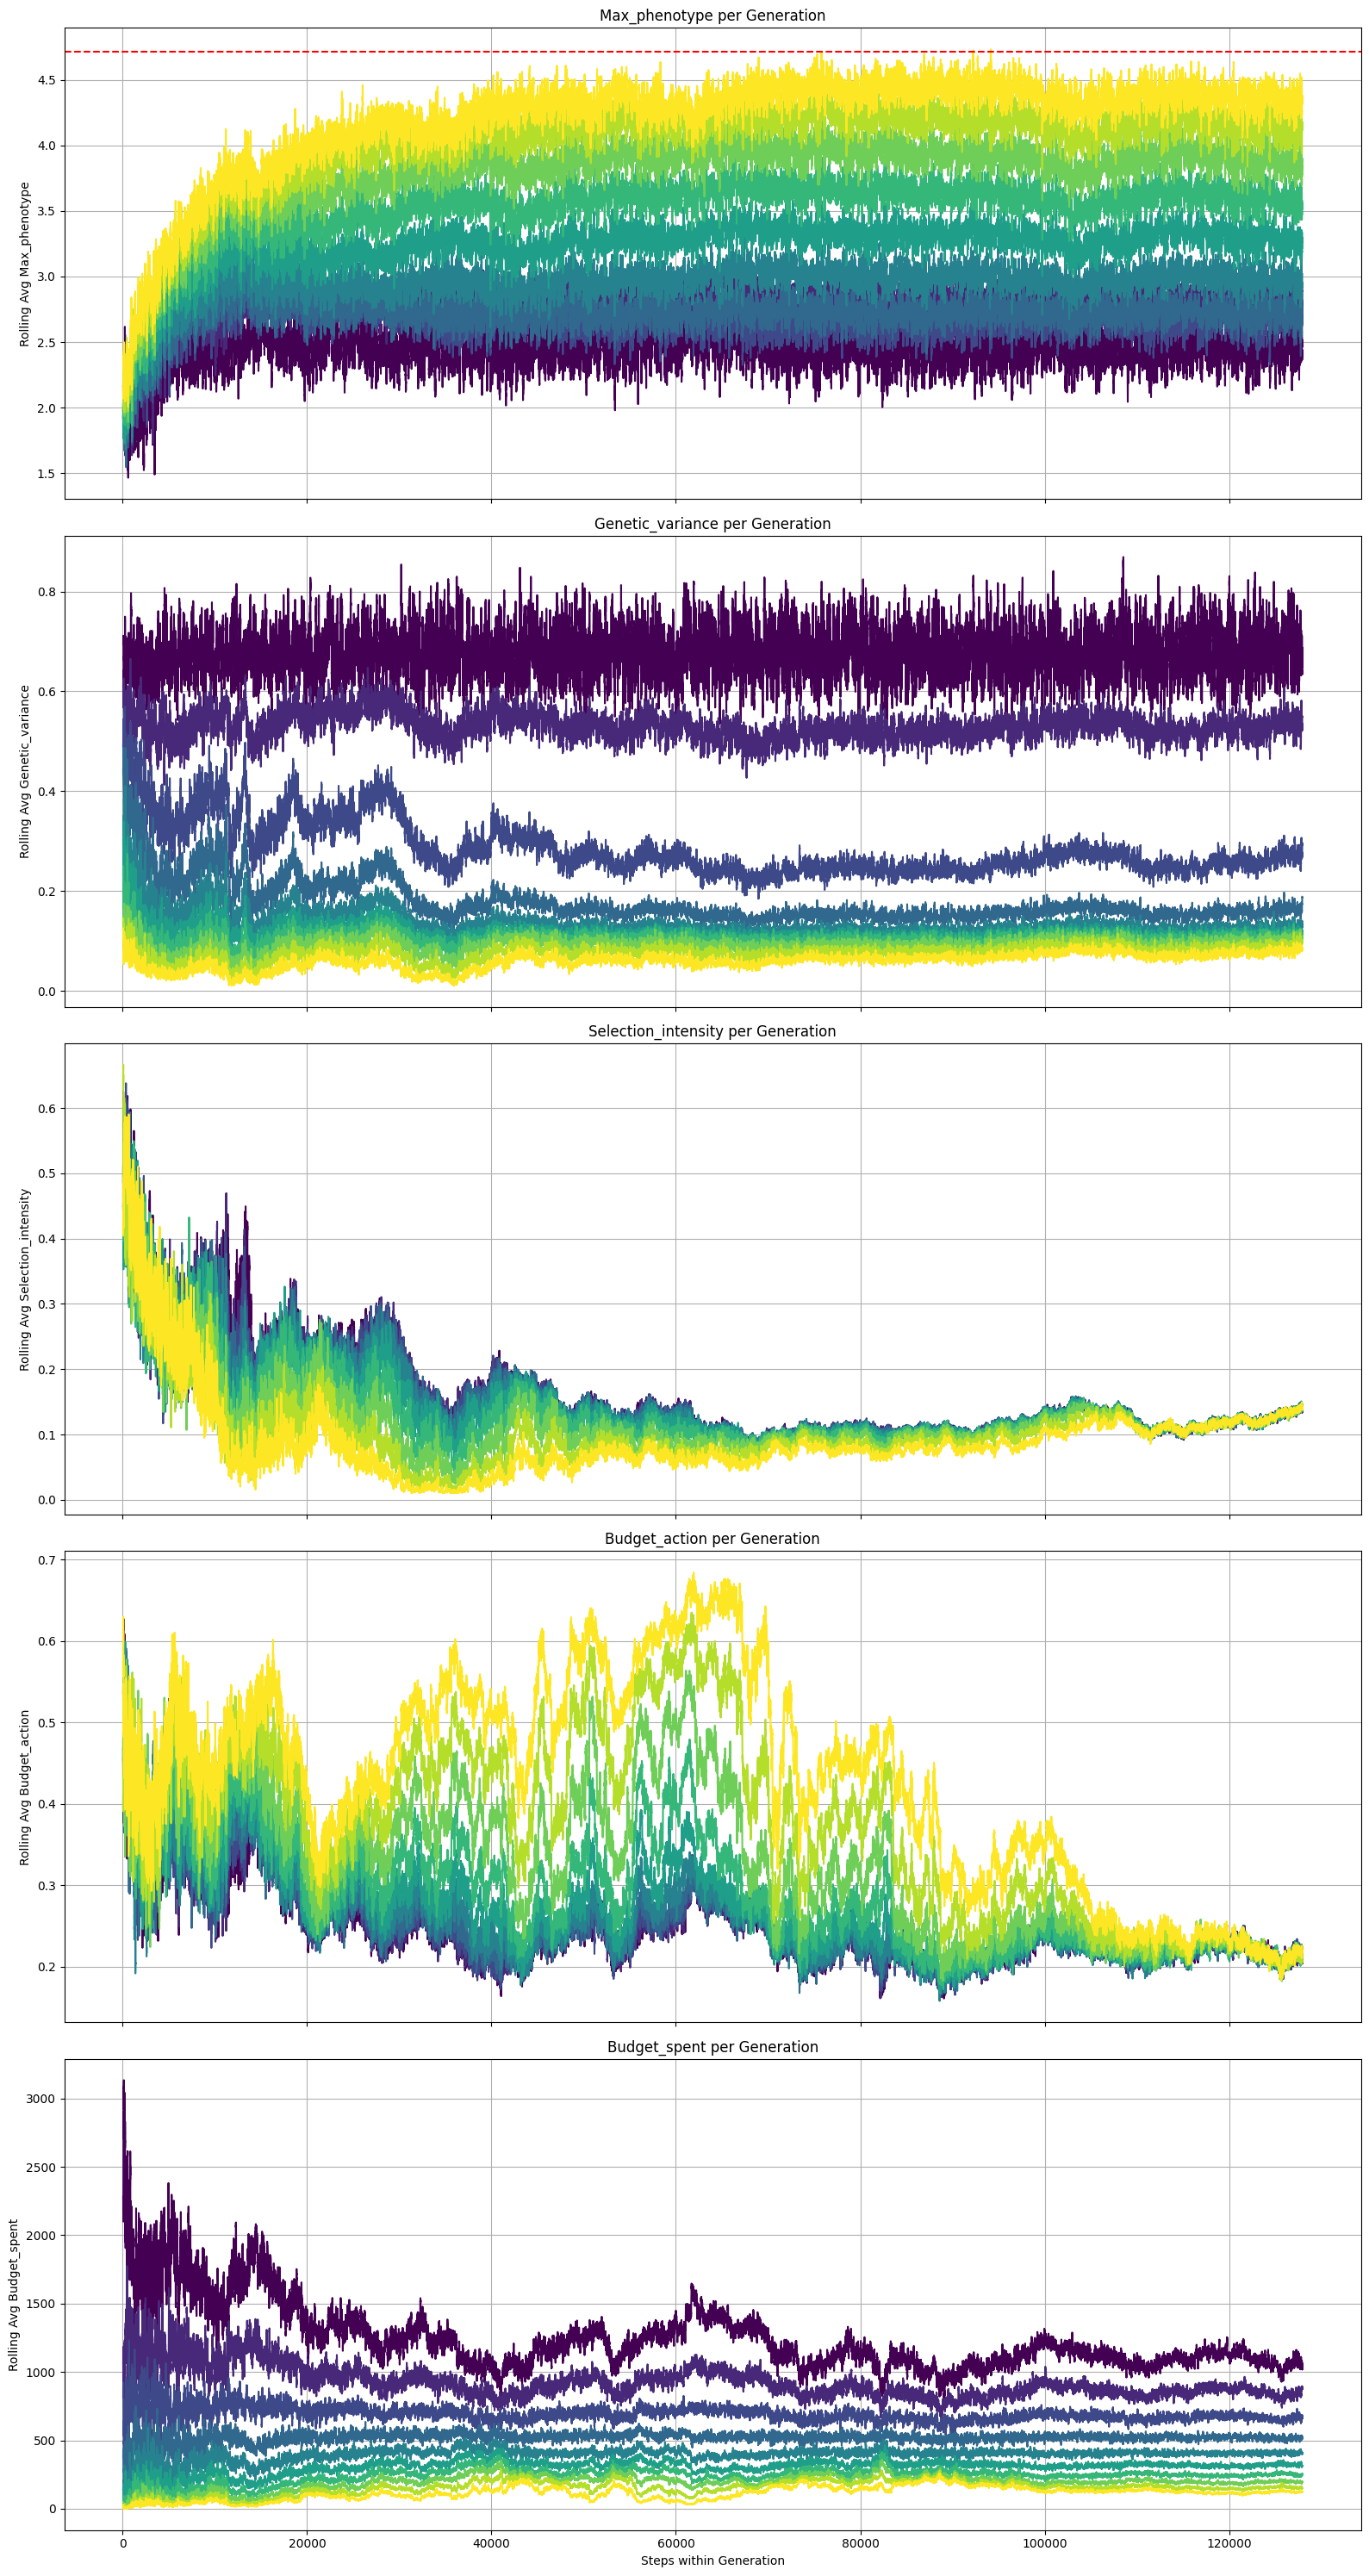

KeyboardInterrupt: 

In [16]:
agent.learn(total_timesteps=1000000 ,callback = callback)

In [ ]:

config = SimulationConfig()
config.max_generations = 10
config.sparse_reward = True
config.seed = 2
SP = SimParams(config)
breeder_env = BudgetEnv(SP, starting_budget=5000)

agent = PPO("MultiInputPolicy", breeder_env)
agent.learn(total_timesteps=1000000 ,callback = callback)